In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import copy
import pickle
from functools import reduce

# Helpers

In [2218]:
def do_sum(x1, x2): 
    return x1 + x2

def set_default():
    p_severity = [0.05, 0.75, 0.2] # asymptomatic/mild/severe ratio. 
    s_pcr = 0.7 #sensitivy of PCR test
    s_ct = 0.95 #sensitivity of CT test
    onetest = False
    

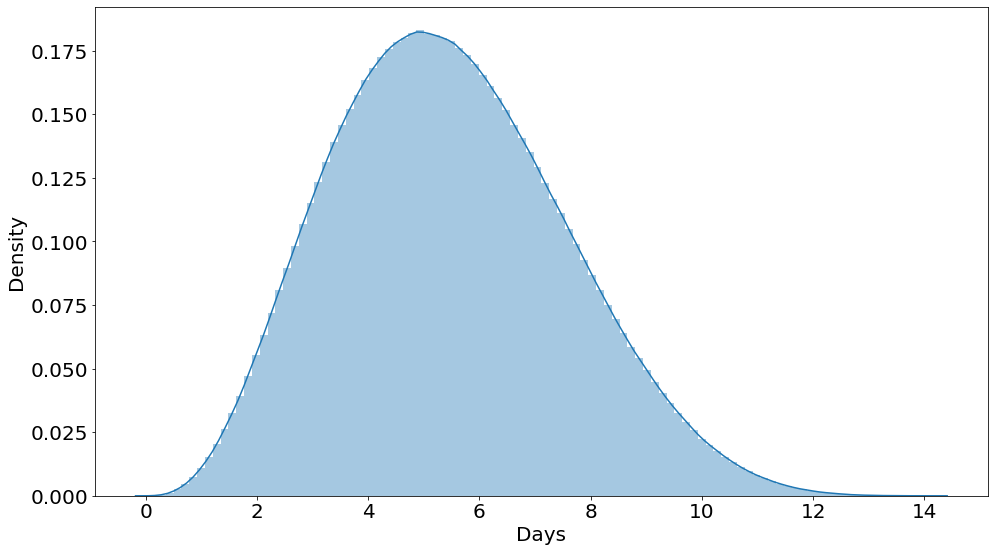

In [1937]:
sample =np.random.beta(4, 7, size=10000000) * 15
# sample = np.random.gamma(12, scale=.4, size=500000)

fig, ax = plt.subplots(figsize=(16,9))
ax.tick_params(labelsize=20)
ax.set_xlabel('Days', fontsize=20)
ax.set_ylabel('Density', fontsize=20)

sns.distplot(sample, ax=ax, bins=100)

beta_t = (np.histogram(sample, bins = range(15))[0] / len(sample))

# Archive

In [6]:
# v0.1 working. Tracing is not efficient
p_severity = [0.05, 0.75, 0.2]
s_pcr = 0.7 #sensitivy of PCR test
s_ct = 0.95 #sensitivity of CT test

"""
P_pcr: 
P_ct: 
D_s
D_m
TP_s
TP_m
TP_ct
"""
class World:
    def __init__(self, initial_infection):
        self.day = 0
        self.cohort = []
        for i in range(initial_infection):
            self.cohort.append(
                Patient(infection_day = self.day, my_id=i, get_from=-1, 
                        my_type=np.random.choice(3, p=p_severity)
                       )
            )
        self.history = pd.DataFrame()
        self.report_today = 0
        self.update()
        
    
    def step(self, r, d_s=4, d_m=4, tp_m=0, trace_rate=0):
        self.day += 1
        self.report_today = 0
        self.trace_cases = []
        self.test(d_s, d_m, tp_m)
        self.transmit(r)
        self.trace(trace_rate)
        self.update()
        
    def test(self, d_s, d_m, tp_m):
        for i in self.severe:
            if self.cohort[i].onset_day + d_s <= self.day and np.random.random() < s_pcr:
                self.cohort[i].type = 3
                self.report_today += 1
                self.trace_cases.append(i)
                    
        if tp_m > 0:
            for i in self.mild:
                if self.cohort[i].onset_day + d_m <= self.day and np.random.random() < s_pcr:
                    self.cohort[i].type = 3
                    self.report_today += 1
                    self.trace_cases.append(i)
                

    def transmit(self, r):
        for i in self.cohort:
            if i.type == 1 or i.type == 2:
                i.patient_infect(self.day, r)
                
    
    def trace(self, trace_rate):
        if trace_rate == 0:
            return
        self.untraced = [i for i in self.cohort if i.type in [0,1,2]]
        for i in self.trace_cases:
            for j in self.untraced:
                if j.get_from == i and np.random.random() < trace_rate:
                    j.type = 4
            
            
            
        
    
    def update(self):
        self.infected = len(self.cohort)
        self.asyptomatic = pd.Series(i.id for i in self.cohort if i.type == 0)
        self.mild = pd.Series(i.id for i in self.cohort if i.type == 1)
        self.severe = pd.Series(i.id for i in self.cohort if i.type == 2)
        self.isolated = pd.Series(i.id for i in self.cohort if i.type == 3)
        self.traced = pd.Series(i.id for i in self.cohort if i.type == 4)
        self.history.at[self.day, 'asyptomatic'] = len(self.asyptomatic)
        self.history.at[self.day, 'mild'] = len(self.mild)
        self.history.at[self.day, 'severe'] = len(self.severe)
        self.history.at[self.day, 'isolated'] = len(self.isolated)
        self.history.at[self.day, 'traced'] = len(self.traced)
        self.history.at[self.day, 'report'] = self.report_today
    
        self.history = self.history.astype(int)
    
            

class Patient:
    def __init__(self, infection_day, my_id, get_from, my_type):
        self.infection_day = infection_day
        self.onset_day = int(np.random.weibull(a=2.04) / 0.103) + self.infection_day
        self.id = my_id
        self.get_from = get_from
        self.type = my_type
        
    def patient_infect(self, current_day, r):
#         if np.random.random() < 0.01:
#             print(current_day)
#             print(self.infection_day)
#             print('------')
        tau = int(current_day - self.infection_day)
        if  tau <= 13 and self.type in [1,2]:
            if np.random.random() < r * beta_t[tau]:
                world.cohort.append(Patient(
                    infection_day = current_day, my_id = len(world.cohort), get_from = self.id,
                    my_type=np.random.choice(3, p=p_severity)
                ))
                
        
        


In [7]:
# v0.2 tracing better implemented, still not fast enough
p_severity = [0.05, 0.75, 0.2]
s_pcr = 0.7 #sensitivy of PCR test
s_ct = 0.95 #sensitivity of CT test

"""
P_pcr: 
P_ct: 
D_s
D_m
TP_s
TP_m
TP_ct
"""
class World:
    def __init__(self, initial_infection):
        self.day = 0
        self.cohort = []
        for i in range(initial_infection):
            self.cohort.append(
                Patient(infection_day = self.day, my_id=i, get_from=-1, 
                        my_type=np.random.choice(3, p=p_severity)
                       )
            )
        self.history = pd.DataFrame()
        self.report_today = 0
        self.update()
        
    
    def step(self, r, d_s=4, d_m=4, tp_m=0, trace_rate=0):
        self.day += 1
        self.report_today = 0
        self.trace_cases = []
        self.test(d_s, d_m, tp_m)
        self.transmit(r)
        self.trace(trace_rate)
        self.update()
        
    def test(self, d_s, d_m, tp_m):
        for i in self.severe:
            if self.cohort[i].onset_day + d_s <= self.day and np.random.random() < s_pcr:
                self.cohort[i].type = 3
                self.report_today += 1
                self.trace_cases.append(i)
                    
        if tp_m > 0:
            for i in self.mild:
                if self.cohort[i].onset_day + d_m <= self.day and np.random.random() < s_pcr:
                    self.cohort[i].type = 3
                    self.report_today += 1
                    self.trace_cases.append(i)
                

    def transmit(self, r):
        for i in self.cohort:
            if i.type == 1 or i.type == 2:
                i.patient_infect(self.day, r)
                
    
    def trace(self, trace_rate):
        if trace_rate == 0:
            return
        
        untraced = np.sort(np.append(np.append(world.asyptomatic, world.mild), world.severe))
        sub_patients = [i[1] for i in world.transition_chain if i[0] in world.trace_cases]
        for i in sub_patients:
            if self.cohort[i].type in [0,1,2]:
                self.cohort[i].type = 4
        
    
    def update(self):
        self.infected = len(self.cohort)
        self.transition_chain = [(i.get_from, i.id) for i in world.cohort]
        self.asyptomatic = pd.Series(i.id for i in self.cohort if i.type == 0)
        self.mild = pd.Series(i.id for i in self.cohort if i.type == 1)
        self.severe = pd.Series(i.id for i in self.cohort if i.type == 2)
        self.isolated = pd.Series(i.id for i in self.cohort if i.type == 3)
        self.traced = pd.Series(i.id for i in self.cohort if i.type == 4)
        self.history.at[self.day, 'asyptomatic'] = len(self.asyptomatic)
        self.history.at[self.day, 'mild'] = len(self.mild)
        self.history.at[self.day, 'severe'] = len(self.severe)
        self.history.at[self.day, 'isolated'] = len(self.isolated)
        self.history.at[self.day, 'traced'] = len(self.traced)
        self.history.at[self.day, 'report'] = self.report_today
    
        self.history = self.history.astype(int)
    
            

class Patient:
    def __init__(self, infection_day, my_id, get_from, my_type):
        self.infection_day = infection_day
        self.onset_day = int(np.random.weibull(a=2.04) / 0.103) + self.infection_day
        self.id = my_id
        self.get_from = get_from
        self.type = my_type
        
    def patient_infect(self, current_day, r):
#         if np.random.random() < 0.01:
#             print(current_day)
#             print(self.infection_day)
#             print('------')
        tau = int(current_day - self.infection_day)
        if  tau <= 13 and self.type in [1,2]:
            if np.random.random() < r * beta_t[tau]:
                world.cohort.append(Patient(
                    infection_day = current_day, my_id = len(world.cohort), get_from = self.id,
                    my_type=np.random.choice(3, p=p_severity)
                ))

In [ ]:
# v0.3 Working. add asymtomatic transimssion

p_severity = [0.05, 0.75, 0.2]
s_pcr = 0.7 #sensitivy of PCR test
s_ct = 0.1 #sensitivity of CT test

"""
P_pcr: 
P_ct: 
D_s
D_m
TP_s
TP_m
TP_ct
"""
class World:
    def __init__(self, initial_infection):
        self.day = 0
        self.cohort = []
        for i in range(initial_infection):
            self.cohort.append(
                Patient(infection_day = self.day, my_id=i, get_from=-1, 
                        my_type=np.random.choice(3, p=p_severity)
                       )
            )
        self.history = pd.DataFrame()
        self.report_today = 0
        self.update()
        
    
    def step(self, r, d_s=4, d_m=4, tp_m=0, trace_rate=0):
        self.day += 1
        self.report_today = 0
        self.trace_cases = [] # whether reset trace case
        
        self.test(d_s, d_m, tp_m)
        self.transmit(r)
        self.trace(trace_rate)
        self.update()
        
    def test(self, d_s, d_m, tp_m):
        # whether reset trace case
        for i in self.severe:
            if self.cohort[i].onset_day + d_s <= self.day and np.random.random() < s_pcr:
                self.cohort[i].type = 3
                self.report_today += 1
                self.trace_cases.append(i)
                    
        if tp_m > 0:
            for i in self.mild:
                if self.cohort[i].onset_day + d_m <= self.day and np.random.random() < s_pcr:
                    self.cohort[i].type = 3
                    self.report_today += 1
                    self.trace_cases.append(i)
                

    def transmit(self, r):
        for i in self.cohort:
            if i.type == 1 or i.type == 2:
                i.patient_infect(self.day, r)
            if i.type == 0:
                i.patient_infect(self.day, r/10)
                
    
    def trace(self, trace_rate):
        if trace_rate == 0:
            return
        
        untraced = np.sort(np.append(np.append(world.asyptomatic, world.mild), world.severe))
        sub_patients = [i[1] for i in world.transition_chain if i[0] in world.trace_cases]
        for i in sub_patients:
            if self.cohort[i].type in [0,1,2] and np.random.random()<trace_rate:
                self.cohort[i].type = 4
                
        # traced isolated case transfer to positive isolation once show symptom        
        for i in self.traced:
            if self.cohort[i].onset_day <= self.day:
                self.cohort[i].type = 3
                self.report_today += 1
                
        
    
    def update(self):
        self.infected = len(self.cohort)
        self.transition_chain = [(i.get_from, i.id) for i in world.cohort]
        self.asyptomatic = pd.Series(i.id for i in self.cohort if i.type == 0)
        self.mild = pd.Series(i.id for i in self.cohort if i.type == 1)
        self.severe = pd.Series(i.id for i in self.cohort if i.type == 2)
        self.isolated = pd.Series(i.id for i in self.cohort if i.type == 3)
        self.traced = pd.Series(i.id for i in self.cohort if i.type == 4)
        self.history.at[self.day, 'asyptomatic'] = len(self.asyptomatic)
        self.history.at[self.day, 'mild'] = len(self.mild)
        self.history.at[self.day, 'severe'] = len(self.severe)
        self.history.at[self.day, 'isolated'] = len(self.isolated)
        self.history.at[self.day, 'traced'] = len(self.traced)
        self.history.at[self.day, 'report'] = self.report_today
    
        self.history = self.history.astype(int)
    
            

class Patient:
    def __init__(self, infection_day, my_id, get_from, my_type):
        self.infection_day = infection_day
        self.onset_day = int(np.random.weibull(a=2.04) / 0.103) + self.infection_day
        self.id = my_id
        self.get_from = get_from
        self.type = my_type
        
    def patient_infect(self, current_day, r):
#         if np.random.random() < 0.01:
#             print(current_day)
#             print(self.infection_day)
#             print('------')
        tau = int(current_day - self.infection_day)
        if  tau <= 13 and self.type in [1,2]:
            if np.random.random() < r * beta_t[tau]:
                world.cohort.append(Patient(
                    infection_day = current_day, my_id = len(world.cohort), get_from = self.id,
                    my_type=np.random.choice(3, p=p_severity)
                ))

In [ ]:
# v0.4 Adjust CT prescan procedure, add CT positive to traced

p_severity = [0.05, 0.75, 0.2] # asymptomatic/mild/severe ratio. 
s_pcr = 0.7 #sensitivy of PCR test
s_ct = 0.85 #sensitivity of CT test

"""
P_pcr: 
P_ct: 
D_s
D_m
TP_s
TP_m
TP_ct
"""
class World:
    def __init__(self, initial_infection):
        self.day = 0
        self.cohort = []
        for i in range(initial_infection):
            self.cohort.append(
                Patient(infection_day = self.day, my_id=i, get_from=-1, 
                        my_type=np.random.choice(3, p=p_severity)
                       )
            )
        self.history = pd.DataFrame()
        self.report_today = 0
        self.trace_cases = []
        self.update()
        
    
    def step(self, r, d_s=4, d_m=4, tp_m=0, trace_rate=0, ct=0):
        self.day += 1
        self.report_today = 0
        self.trace_cases = [] # whether reset trace case
        
        self.test(d_s, d_m, tp_m, ct)
        self.transmit(r)
        self.trace(trace_rate)
        self.update()
        
    def test(self, d_s, d_m, tp_m, ct):
        # whether reset trace case
        if ct> 0 :
            for i in np.append(self.mild, self.severe).astype(int):
                if self.cohort[i].onset_day + 1 <= self.day and np.random.random() < s_ct:
                    self.cohort[i].type = 4
                    self.report_today += 1
                    self.trace_cases.append(i)
        
        for i in self.severe:
            if self.cohort[i].onset_day + d_s <= self.day and np.random.random() < s_pcr:
                self.cohort[i].type = 3
                self.report_today += 1
                self.trace_cases.append(i)
                    
        if tp_m > 0:
            for i in self.mild:
                if self.cohort[i].onset_day + d_m <= self.day and np.random.random() < s_pcr:
                    self.cohort[i].type = 3
                    self.report_today += 1
                    self.trace_cases.append(i)
                

                

    def transmit(self, r):
        for i in self.cohort:
            if i.type == 1 or i.type == 2:
                i.patient_infect(self.day, r)
            if i.type == 0:
                i.patient_infect(self.day, r/10)
                
    
    def trace(self, trace_rate):
        # traced isolated case transfer to positive isolation once show symptom        
        for i in self.traced:
            if self.cohort[i].onset_day <= self.day:
                self.cohort[i].type = 3
                self.report_today += 1
        
        if trace_rate == 0:
            return
        
        untraced = np.sort(np.append(np.append(world.asyptomatic, world.mild), world.severe).astype(int))
        sub_patients = [i[1] for i in world.transition_chain if i[0] in world.trace_cases]
        for i in sub_patients:
            if self.cohort[i].type in [0,1,2] and np.random.random()<trace_rate:
                self.cohort[i].type = 4
        
    
    def update(self):
        self.infected = len(self.cohort)
        self.transition_chain = [(i.get_from, i.id) for i in world.cohort]
        self.asyptomatic = pd.Series(i.id for i in self.cohort if i.type == 0)
        self.mild = pd.Series(i.id for i in self.cohort if i.type == 1)
        self.severe = pd.Series(i.id for i in self.cohort if i.type == 2)
        self.isolated = pd.Series(i.id for i in self.cohort if i.type == 3)
        self.traced = pd.Series(i.id for i in self.cohort if i.type == 4)
        self.history.at[self.day, 'asyptomatic'] = len(self.asyptomatic)
        self.history.at[self.day, 'mild'] = len(self.mild)
        self.history.at[self.day, 'severe'] = len(self.severe)
        self.history.at[self.day, 'isolated'] = len(self.isolated)
        self.history.at[self.day, 'traced'] = len(self.traced)
        self.history.at[self.day, 'report'] = self.report_today
    
        self.history = self.history.astype(int)
    
            

class Patient:
    def __init__(self, infection_day, my_id, get_from, my_type):
        self.infection_day = infection_day
        self.onset_day = int(np.random.weibull(a=2.04) / 0.103) + self.infection_day
        self.id = my_id
        self.get_from = get_from
        self.type = my_type
        
    def patient_infect(self, current_day, r):
#         if np.random.random() < 0.01:
#             print(current_day)
#             print(self.infection_day)
#             print('------')
        tau = int(current_day - self.infection_day)
        if  tau <= 13 and self.type in [0,1,2]:
            if np.random.random() < r * beta_t[tau]:
                world.cohort.append(Patient(
                    infection_day = current_day, my_id = len(world.cohort), get_from = self.id,
                    my_type=np.random.choice(3, p=p_severity)
                ))

In [ ]:
# v0.5 Optimize tracing method

p_severity = [0.05, 0.75, 0.2] # asymptomatic/mild/severe ratio. 
s_pcr = 0.7 #sensitivy of PCR test
s_ct = 0.95 #sensitivity of CT test

"""
s_pcr: sensitivity of PCR test (right now undifferentiated between mild and severe cases and time, worth consider)
s_ct: sensitivity of CT test (right now not varied based on time)
d_s: delay between symptom onset and isolation (due to positive PCR test) for severe cases
d_m: delay between symptom onset and isolation (due to positive PCR test) for mild cases
tp_m: the chance a mild case get tested (daily)
trace_rate: the fraction of an indentified case' contacts that is quarantined
ct: whether to use CT as pre-screening
"""


class World:
    def __init__(self, initial_infection):
            self.day = 0
            self.cohort = []
            for i in range(initial_infection):
                self.cohort.append(
                    Patient(infection_day = self.day, my_id=i, close_contacts=[],
                                          my_type=np.random.choice(3, p=p_severity))
                )
            self.history = pd.DataFrame()
            self.report_today = 0
            self.trace_cases = []
            self.update()
            
    def update(self):
        self.infected = len(self.cohort)
        
        self.asyptomatic = pd.Series(i.id for i in self.cohort if i.type == 0)
        self.mild = pd.Series(i.id for i in self.cohort if i.type == 1)
        self.severe = pd.Series(i.id for i in self.cohort if i.type == 2)
        self.isolated = pd.Series(i.id for i in self.cohort if i.type == 3)
        self.traced = pd.Series(i.id for i in self.cohort if i.type == 4)
        self.screened = pd.Series(i.id for i in self.cohort if i.type == 5)
        
        self.history.at[self.day, 'infected'] = self.infected
        self.history.at[self.day, 'asyptomatic'] = len(self.asyptomatic)
        self.history.at[self.day, 'mild'] = len(self.mild)
        self.history.at[self.day, 'severe'] = len(self.severe)
        self.history.at[self.day, 'isolated'] = len(self.isolated)
        self.history.at[self.day, 'traced'] = len(self.traced)
        self.history.at[self.day, 'screened'] = len(self.traced)
        self.history.at[self.day, 'report'] = self.report_today
    
        self.history = self.history.astype(int)
        
    def step(self, r, d_s=4, d_m=4, tp_m=0, trace_rate=0, ct=0):
        self.day += 1
        self.report_today = 0
        self.trace_cases = []
        self.test(d_s, d_m, tp_m, ct)
        self.transmit(r)
        self.trace(trace_rate)
        self.referral()
        self.update()
        
    
    def test(self, d_s, d_m, tp_m, ct):
        if ct> 0 :
            for i in np.append(self.mild, self.severe).astype(int):
                if self.cohort[i].onset_day + 1 <= self.day and np.random.random() < s_ct:
                    self.cohort[i].type = 5
                    self.report_today += 1
                    self.trace_cases.append(i)
                    
        for i in self.severe:
            if self.cohort[i].onset_day + d_s <= self.day and np.random.random() < s_pcr:
                self.cohort[i].type = 3
                self.report_today += 1
                self.trace_cases.append(i)
                
        if tp_m > 0:
            for i in self.mild:
                if self.cohort[i].onset_day + d_m <= self.day and np.random.random() < s_pcr:
                    self.cohort[i].type = 3
                    self.report_today += 1
                    self.trace_cases.append(i)
                    
    def transmit(self, r):
        """
        Assuming asymptomatic individuals have transmicity 1/10 of presymptomatic/symptomatic individuals, based on 
        Quantifying SARS-CoV-2 transmission suggests epidemic control with digital contact tracing
        """
        for i in self.cohort:
            if i.type == 1 or i.type == 2:
                i.patient_infect(self.day, r)
            if i.type == 0:
                i.patient_infect(self.day, r/10)
                
    def trace(self, trace_rate):
        if trace_rate > 0:
            for i in self.trace_cases:
                for j in self.cohort[i].close_contacts:
                    if self.cohort[j].type in [0,1,2] and np.random.random() < trace_rate:
                        self.cohort[j].type = 4
                        
    def referral(self):
        for i in self.traced:
            if self.cohort[i].onset_day <= self.day:
                self.cohort[i].type = 3
                self.report_today += 1
                
        for i in self.screened:
            if self.cohort[i].onset_day <= self.day:
                self.cohort[i].type = 3
                self.report_today += 1                    
                    
        
        
class Patient:
    def __init__(self, infection_day, my_id, close_contacts, my_type):
        self.infection_day = infection_day
        self.onset_day = int(np.random.weibull(a=2.04) / 0.103) + self.infection_day
        self.id = my_id
        self.close_contacts = []
        self.type = my_type
        
    def patient_infect(self, day, r):
        tau = int(day - self.infection_day)
        if tau <= 13 and self.type in [0,1,2]:
            if np.random.random() < r * beta_t[tau]:
                world.cohort.append(
                    Patient(infection_day=day, my_id=len(world.cohort), close_contacts=[],
                                           my_type=np.random.choice(3, p=p_severity))
                )
                self.close_contacts.append(len(world.cohort)-1)
            

In [ ]:
# v0.6 False negative once and for all for mild cases (optinal)

p_severity = [0.05, 0.75, 0.2] # asymptomatic/mild/severe ratio. 
s_pcr = 0.7 #sensitivy of PCR test
s_ct = 0.95 #sensitivity of CT test


"""
s_pcr: sensitivity of PCR test (right now undifferentiated between mild and severe cases and time, worth consider)
s_ct: sensitivity of CT test (right now not varied based on time)
d_s: delay between symptom onset and isolation (due to positive PCR test) for severe cases
d_m: delay between symptom onset and isolation (due to positive PCR test) for mild cases
tp_m: the chance a mild case get tested (daily)
trace_rate: the fraction of an indentified case' contacts that is quarantined
ct: whether to use CT as pre-screening
"""


class World:
    def __init__(self, initial_infection):
            self.day = 0 # time counter
            self.cohort = [] # list to store all the Patient objects
            for i in range(initial_infection): 
                self.cohort.append(
                    Patient(infection_day = self.day, my_id=i, close_contacts=[],
                                          my_type=np.random.choice(3, p=p_severity))
                )
            self.history = pd.DataFrame() # data recording
            self.report_today = 0 # everyday's confirm cases, as opposed to infections
            self.trace_cases = [] # used to keep record of identified cases today for contact tracing
            self.update() # update all attributes
            
    def update(self):
        self.infected = len(self.cohort) # total number of infections
        
        self.asyptomatic = pd.Series(i.id for i in self.cohort if i.type == 0)
        self.mild = pd.Series(i.id for i in self.cohort if i.type == 1)
        self.severe = pd.Series(i.id for i in self.cohort if i.type == 2)
        self.isolated = pd.Series(i.id for i in self.cohort if i.type == 3) # when a case is tested positive by PCR
        self.traced = pd.Series(i.id for i in self.cohort if i.type == 4) # when a case is isolated from contact tracing
        self.screened = pd.Series(i.id for i in self.cohort if i.type == 5) # when a case is screened positive by CT
        
        self.history.at[self.day, 'infected'] = self.infected
        self.history.at[self.day, 'asyptomatic'] = len(self.asyptomatic)
        self.history.at[self.day, 'mild'] = len(self.mild)
        self.history.at[self.day, 'severe'] = len(self.severe)
        self.history.at[self.day, 'isolated'] = len(self.isolated)
        self.history.at[self.day, 'traced'] = len(self.traced)
        self.history.at[self.day, 'screened'] = len(self.traced)
        self.history.at[self.day, 'report'] = self.report_today
    
        self.history = self.history.astype(int)
        
    def step(self, r, d_s=4, d_m=4, tp_m=0, trace_rate=0, ct=0):
        self.day += 1
        self.report_today = 0
        self.trace_cases = [] # reset list for contact tracing, optional
        self.test(d_s, d_m, tp_m, ct)
        self.transmit(r)
        self.trace(trace_rate)
        self.referral()
        self.update()
        
    
    def test(self, d_s, d_m, tp_m, ct):
        if ct> 0 :
            for i in self.severe:
                if self.cohort[i].onset_day + 1 <= self.day and np.random.random() < s_ct:
                    self.cohort[i].type = 5
                    self.report_today += 1
                    self.trace_cases.append(i)
                    
            for i in self.mild:
                if (not self.cohort[i].tested) and self.cohort[i].onset_day + 1 <= self.day:
                    if np.random.random() < s_ct:
                        self.cohort[i].type = 5
                        self.report_today += 1
                        self.trace_cases.append(i)
                    else:
                        self.cohort[i].tested = True
                    
        for i in self.severe:
            if self.cohort[i].onset_day + d_s <= self.day and np.random.random() < s_pcr:
                self.cohort[i].type = 3
                self.report_today += 1
                self.trace_cases.append(i)
                
        if tp_m > 0:
            for i in self.mild:
                if (not self.cohort[i].tested) and self.cohort[i].onset_day + d_m <= self.day:
                    if np.random.random() < s_pcr:                
                        self.cohort[i].type = 3
                        self.report_today += 1
                        self.trace_cases.append(i)
                    else:
                        self.cohort[i].tested = True
                    
    def transmit(self, r):
        """
        Assuming asymptomatic individuals have transmicity 1/10 of presymptomatic/symptomatic individuals, based on 
        Quantifying SARS-CoV-2 transmission suggests epidemic control with digital contact tracing
        """
        for i in self.cohort:
            if i.type == 1 or i.type == 2:
                i.patient_infect(self.day, r)
            if i.type == 0:
                i.patient_infect(self.day, r/10)
                
    def trace(self, trace_rate):
        if trace_rate > 0:
            for i in self.trace_cases:
                for j in self.cohort[i].close_contacts:
                    if self.cohort[j].type in [0,1,2] and np.random.random() < trace_rate:
                        self.cohort[j].type = 4
                        
    def referral(self):
        for i in self.traced:
            if self.cohort[i].onset_day <= self.day:
                self.cohort[i].type = 3
                self.report_today += 1
                
        for i in self.screened:
            if self.cohort[i].onset_day <= self.day:
                self.cohort[i].type = 3
                self.report_today += 1                    
                    
        
        
class Patient:
    def __init__(self, infection_day, my_id, close_contacts, my_type):
        self.infection_day = infection_day
        self.onset_day = int(np.random.weibull(a=2.04) / 0.103) + self.infection_day
        self.id = my_id
        self.close_contacts = []
        self.type = my_type
        self.tested = False
        
    def patient_infect(self, day, r):
        tau = int(day - self.infection_day)
        if tau <= 13 and self.type in [0,1,2]:
            if np.random.random() < r * beta_t[tau]:
                world.cohort.append(
                    Patient(infection_day=day, my_id=len(world.cohort), close_contacts=[],
                                           my_type=np.random.choice(3, p=p_severity))
                )
                self.close_contacts.append(len(world.cohort)-1)
            

# Main Objects

In [2224]:
# v0.7 Make all variant external parameter, so that a world can switch parameter mid-run, add generation

p_severity = [0.05, 0.75, 0.2] # asymptomatic/mild/severe ratio. 
s_pcr = 0.7 #sensitivy of PCR test
s_ct = 0.95 #sensitivity of CT test
onetest = False

"""
s_pcr: sensitivity of PCR test (right now undifferentiated between mild and severe cases and time, worth consider)
s_ct: sensitivity of CT test (right now not varied based on time)
d_s: delay between symptom onset and isolation (due to positive PCR test) for severe cases
d_m: delay between symptom onset and isolation (due to positive PCR test) for mild cases
tp_m: the chance a mild case get tested (daily)
trace_rate: the fraction of an indentified case' contacts that is quarantined
ct: whether to use CT as pre-screening
"""


class World:
    def __init__(self, initial_infection):
            self.day = 0 # time counter
            self.cohort = [] # list to store all the Patient objects
            for i in range(initial_infection): 
                self.cohort.append(
                    Patient(infection_day = self.day, my_id=i, close_contacts=[],
                                          my_type=np.random.choice(3, p=p_severity), generation=0)
                )
            self.history = pd.DataFrame() # data recording
            self.report_today = 0 # everyday's confirm cases, as opposed to infections
            self.trace_cases = [] # used to keep record of identified cases today for contact tracing
            self.update() # update all attributes
            
    def update(self):
        self.infected = len(self.cohort) # total number of infections
        
        self.asyptomatic = pd.Series(i.id for i in self.cohort if i.type == 0)
        self.mild = pd.Series(i.id for i in self.cohort if i.type == 1)
        self.severe = pd.Series(i.id for i in self.cohort if i.type == 2)
        self.isolated = pd.Series(i.id for i in self.cohort if i.type == 3) # when a case is tested positive by PCR
        self.traced = pd.Series(i.id for i in self.cohort if i.type == 4) # when a case is isolated from contact tracing
        self.screened = pd.Series(i.id for i in self.cohort if i.type == 5) # when a case is screened positive by CT
        
        self.history.at[self.day, 'infected'] = self.infected
        self.history.at[self.day, 'asyptomatic'] = len(self.asyptomatic)
        self.history.at[self.day, 'mild'] = len(self.mild)
        self.history.at[self.day, 'severe'] = len(self.severe)
        self.history.at[self.day, 'isolated'] = len(self.isolated)
        self.history.at[self.day, 'traced'] = len(self.traced)
        self.history.at[self.day, 'screened'] = len(self.traced)
        self.history.at[self.day, 'report'] = self.report_today
    
        self.history = self.history.astype(int)
        
    def step(self, r, d_s=4, d_m=4, tp_m=0, trace_rate=0, ct=0, onetest=False):
        self.day += 1
        self.report_today = 0
        self.trace_cases = [] # reset list for contact tracing, optional
        self.test(d_s, d_m, tp_m, ct, onetest)
        self.transmit(r)
        self.trace(trace_rate)
        self.referral()
        self.update()
        
    
    def test(self, d_s, d_m, tp_m, ct, onetest):
        if ct> 0 :
            for i in self.severe:
                if self.cohort[i].onset_day + 1 <= self.day and np.random.random() < s_ct:
                    self.cohort[i].type = 5
                    self.report_today += 1
                    self.trace_cases.append(i)
                    
            for i in self.mild:
                if (not self.cohort[i].tested) and self.cohort[i].onset_day + 1 <= self.day:
                    if np.random.random() < s_ct:
                        self.cohort[i].type = 5
                        self.report_today += 1
                        self.trace_cases.append(i)
                    elif onetest:
                        self.cohort[i].tested = True
                    
        for i in self.severe:
            if self.cohort[i].onset_day + d_s <= self.day and np.random.random() < s_pcr:
                self.cohort[i].type = 3
                self.report_today += 1
                self.trace_cases.append(i)
                
        if tp_m > 0:
            for i in self.mild:
                if (not self.cohort[i].tested) and self.cohort[i].onset_day + d_m <= self.day:
                    if np.random.random() < s_pcr:                
                        self.cohort[i].type = 3
                        self.report_today += 1
                        self.trace_cases.append(i)
                    elif onetest:
                        self.cohort[i].tested = True
                    
    def transmit(self, r):
        """
        Assuming asymptomatic individuals have transmicity 1/10 of presymptomatic/symptomatic individuals, based on 
        Quantifying SARS-CoV-2 transmission suggests epidemic control with digital contact tracing
        """
        for i in self.cohort:
            if i.type == 1 or i.type == 2:
                i.patient_infect(self.day, r)
            if i.type == 0:
                i.patient_infect(self.day, r/10)
                
    def trace(self, trace_rate):
        if trace_rate > 0:
            for i in self.trace_cases:
                for j in self.cohort[i].close_contacts:
                    if self.cohort[j].type in [0,1,2] and np.random.random() < trace_rate:
                        self.cohort[j].type = 4
                        
    def referral(self):
        for i in self.traced:
            if self.cohort[i].onset_day <= self.day:
                self.cohort[i].type = 3
                self.report_today += 1
                
        for i in self.screened:
            if self.cohort[i].onset_day <= self.day:
                self.cohort[i].type = 3
                self.report_today += 1                    
                    
        
        
class Patient:
    def __init__(self, infection_day, my_id, close_contacts, my_type, generation):
        self.infection_day = infection_day
        self.onset_day = int(np.random.weibull(a=2.04) / 0.103) + self.infection_day
        self.id = my_id
        self.close_contacts = []
        self.type = my_type
        self.tested = False
        self.generation = generation
        
    def patient_infect(self, day, r):
        tau = int(day - self.infection_day)
        if tau <= 13 and self.type in [0,1,2]:
            if np.random.random() < r * beta_t[tau]:
                world.cohort.append(
                    Patient(infection_day=day, my_id=len(world.cohort), close_contacts=[],
                                           my_type=np.random.choice(3, p=p_severity), generation=self.generation+1)
                )
                self.close_contacts.append(len(world.cohort)-1)            

# Simulation

## Save and Load

In [ ]:
# name = '125_temp'
# with open(r'simulation/Simulation_result_%s.pkl'%name, 'rb') as input:
#     t = pickle.load(input)
    
# name = '106_temp_aympt'
# with open(r'simulation/Simulation_result_%s.pkl'%name, 'wb') as output:
#     pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)

## Initialize and keep initialization

In [2233]:
# Initialize world and run 20 days without tesing
p_severity = [0.05, 0.75, 0.2] # asymptomatic/mild/severe ratio. 
s_pcr = 0.7 #sensitivy of PCR test
s_ct = 0.95 #sensitivity of CT test
onetest = False

world = World(1000)
offset_days = 30
for i in range(offset_days):
    world.step(r=1.06,
              d_s=4,
              d_m=4,
              tp_m=0,               
              trace_rate=0,
              onetest=False)

initial = copy.deepcopy(world)
print(initial.history.infected.diff().iloc[-1])

22.0


## Run

In [2234]:
t = []

In [2235]:
p_severity = [0.05, 0.75, 0.2] # asymptomatic/mild/severe ratio. 
s_pcr = 0.7 #sensitivy of PCR test
s_ct = 0.95 #sensitivity of CT test
onetest = False

# Different testing strategies from Day 30
for _ in range(10):
    r_star = 1.06
    
    # d_s, d_m, t_m, tracing_rate, CT, onetest
    parameter_matrix = [
        [r_star, 4, 4, 0, 0, 0, onetest],
        [r_star, 4, 4, 1, 0, 0, onetest],
        [r_star, 4, 4, 1, 0.5, 0, onetest],
        [r_star, 4, 4, 1, 0, 1, onetest],
        [r_star, 4, 4, 1, 0.5, 1, onetest],
        
    ]

    result = []
    for i in range(len(parameter_matrix)):    
        world = copy.deepcopy(initial)
        for day in range(60):
            world.step(r=parameter_matrix[i][0],
                   d_s=parameter_matrix[i][1],
                   d_m=parameter_matrix[i][2],
                   tp_m=parameter_matrix[i][3],
                   trace_rate=parameter_matrix[i][4],
                   ct=parameter_matrix[i][5],
                   onetest=parameter_matrix[i][6],       
                    )
        result.append(world.history)

    t.append(result)
    print(len(t))

1
2
3
4
5
6
7
8
9
10


## Scale and plot

In [2236]:
scale = 1
count = len(t)

history1 = (reduce(do_sum, [t[i][0] for i in range(count)])/count * scale).astype(int)
history2 = (reduce(do_sum, [t[i][1] for i in range(count)])/count * scale).astype(int)
history2a = (reduce(do_sum, [t[i][2] for i in range(count)])/count * scale).astype(int)
history3 = (reduce(do_sum, [t[i][3] for i in range(count)])/count * scale).astype(int)
history3a = (reduce(do_sum, [t[i][4] for i in range(count)])/count * scale).astype(int)

In [2237]:
2000 / history1.infected.diff()[offset_days:].reset_index(drop=True).values[0]

90.9090909090909

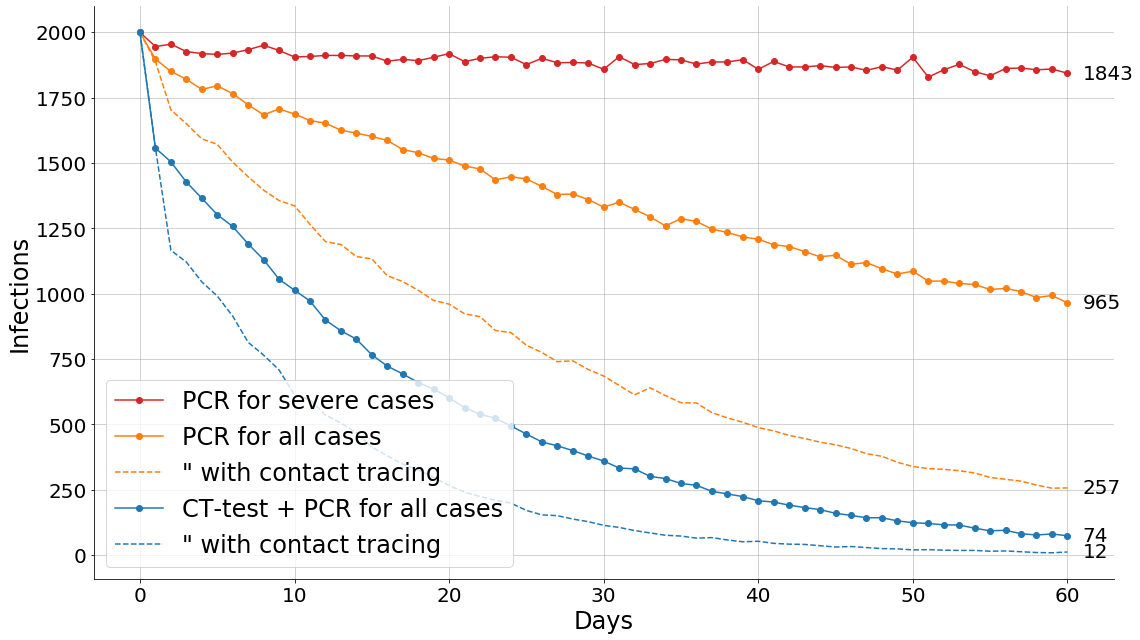

In [1067]:
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(16,9))

ax.plot(history1.infected.diff()[offset_days:].reset_index(drop=True), 'o-',c='C3', label='PCR for severe cases')
ax.plot(history2.infected.diff()[offset_days:].reset_index(drop=True), 'o-',c='C1', label='PCR for all cases')
ax.plot(history2a.infected.diff()[offset_days:].reset_index(drop=True), '--',c='C1', label='\" with contact tracing')
ax.plot(history3.infected.diff()[offset_days:].reset_index(drop=True), 'o-',c='C0', label='CT-test + PCR for all cases')
ax.plot(history3a.infected.diff()[offset_days:].reset_index(drop=True), '--',c='C0', label='\" with contact tracing')

for i in [history1, history2, history3,
          history2a, history3a
         ]:
    ax.annotate(int(i.infected.diff().values[-1]),
                xy=(len(i)-offset_days,i.infected.diff().values[-1]),va='center',ha='left',fontsize=20)
# i = history3.copy()
# ax.annotate(int(99),
#                 xy=(len(i)-offset_days,99),va='center',ha='left',fontsize=20)
    

ax.set_ylabel('Infections',fontsize=24)
ax.set_xlabel('Days', fontsize=24)

ax.tick_params(labelsize=20)
ax.legend(loc=0, fontsize=24)

ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[10]))

ax.grid(alpha=0.7)
plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# name = 'basic_r106'
# with open(r'simulation/Simulation_result_%s.pkl'%name, 'wb') as output:
#     pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)
# with open(r'simulation/Simulation_result_%s.pkl'%name, 'rb') as input:
#     t = pickle.load(input)
plt.savefig(r'figures/for paper/CT/Fig_8.png', dpi=100)

### Compare group scale and plot

In [2238]:
scale = 1
count = len(t)

history1_ = (reduce(do_sum, [t[i][0] for i in range(count)])/count * scale).astype(int)
history2_ = (reduce(do_sum, [t[i][1] for i in range(count)])/count * scale).astype(int)
history2a_ = (reduce(do_sum, [t[i][2] for i in range(count)])/count * scale).astype(int)
history3_ = (reduce(do_sum, [t[i][3] for i in range(count)])/count * scale).astype(int)
history3a_ = (reduce(do_sum, [t[i][4] for i in range(count)])/count * scale).astype(int)

In [2239]:
2000 / history1_.infected.diff()[offset_days:].reset_index(drop=True).values[0]

90.9090909090909

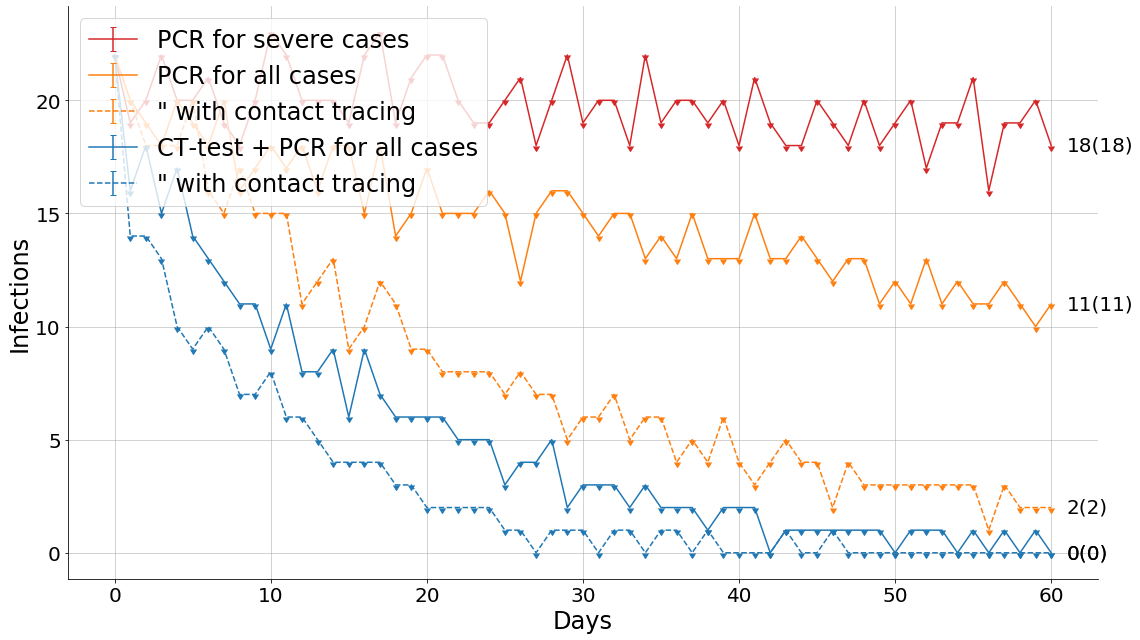

In [2240]:
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(16,9))

yerr = history1.infected.diff()[offset_days:].reset_index(drop=True)-history1_.infected.diff()[offset_days:].reset_index(drop=True)
yerr.iloc[0] = 0
ax.errorbar(x=np.arange(61),y=history1.infected.diff()[offset_days:].reset_index(drop=True), 
            yerr=yerr,c='C3', label='PCR for severe cases', uplims=True)

yerr = history2.infected.diff()[offset_days:].reset_index(drop=True)-history2_.infected.diff()[offset_days:].reset_index(drop=True)
yerr.iloc[0] = 0
ax.errorbar(x=np.arange(61),y=history2.infected.diff()[offset_days:].reset_index(drop=True), 
            yerr=yerr,c='C1', label='PCR for all cases', uplims=True)

yerr = history2a.infected.diff()[offset_days:].reset_index(drop=True)-history2a_.infected.diff()[offset_days:].reset_index(drop=True)
yerr.iloc[0] = 0
ax.errorbar(x=np.arange(61),y=history2a.infected.diff()[offset_days:].reset_index(drop=True), 
            yerr=yerr,c='C1', label='\" with contact tracing', uplims=True, ls='--')

yerr = history3.infected.diff()[offset_days:].reset_index(drop=True)-history3_.infected.diff()[offset_days:].reset_index(drop=True)
yerr.iloc[0] = 0
ax.errorbar(x=np.arange(61),y=history3.infected.diff()[offset_days:].reset_index(drop=True), 
            yerr=yerr,c='C0', label='CT-test + PCR for all cases', uplims=True)

yerr = history3a.infected.diff()[offset_days:].reset_index(drop=True)-history3a_.infected.diff()[offset_days:].reset_index(drop=True)
yerr.iloc[0] = 0
ax.errorbar(x=np.arange(61),y=history3a.infected.diff()[offset_days:].reset_index(drop=True), 
            yerr=yerr,c='C0', label='\" with contact tracing', uplims=True, ls='--')


# ax.plot(history2.infected.diff()[20:].reset_index(drop=True), 'o-',c='C1', label='PCR for all cases')
# ax.plot(history2a.infected.diff()[20:].reset_index(drop=True), '--',c='C1', label='\" with contact tracing')
# ax.plot(history3.infected.diff()[20:].reset_index(drop=True), 'o-',c='C0', label='CT-test + PCR for all cases')
# ax.plot(history3a.infected.diff()[20:].reset_index(drop=True), '--',c='C0', label='\" with contact tracing')

temp = [history1_, history2_, history3_, history2a_, history3a_]
for j,i in enumerate([history1, history2, history3,
          history2a, history3a
         ]):

    ax.annotate(s=str(int(i.infected.diff().values[-1]))+'(%d)'%(int(temp[j].infected.diff().values[-1]))
                ,
                xy=(len(i)-offset_days,i.infected.diff().values[-1]),va='center',ha='left',fontsize=20)
# i = history3.copy()
# ax.annotate(int(99),
#                 xy=(len(i)-20,99),va='center',ha='left',fontsize=20)
    

ax.set_ylabel('Infections',fontsize=24)
ax.set_xlabel('Days', fontsize=24)

ax.tick_params(labelsize=20)
ax.legend(loc='upper left', fontsize=24)

ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[10]))

ax.grid(alpha=0.7)
plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# name = 'sct070_r125'
# with open(r'simulation/Simulation_result_%s.pkl'%name, 'wb') as output:
#     pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)
# with open(r'simulation/Simulation_result_%s.pkl'%name, 'rb') as input:
#     t = pickle.load(input)
# plt.savefig(r'figures/for paper/CT/Fig_9.png', dpi=100)

### Different trace rates scale and plot

In [995]:
t=[]

In [2241]:
#  for different tract rate
for _ in range(50):
    r_star = 1.25
    
    # d_s, d_m, t_m, tracing_rate, CT
    parameter_matrix = [
        [r_star, 4, 4, 1, 0.25, 0],
        [r_star, 4, 4, 1, 0.5, 0],
        [r_star, 4, 4, 1, 0.75, 0],
        [r_star, 4, 4, 1, 0.25, 1],
        [r_star, 4, 4, 1, 0.5, 1],
        [r_star, 4, 4, 1, 0.75, 1],
    ]

    result = []
    for i in range(len(parameter_matrix)):    
        world = copy.deepcopy(initial)
        for day in range(60):
            world.step(r=parameter_matrix[i][0],
                   d_s=parameter_matrix[i][1],
                   d_m=parameter_matrix[i][2],
                   tp_m=parameter_matrix[i][3],
                   trace_rate=parameter_matrix[i][4],
                   ct=parameter_matrix[i][5],
                    )
#         print(i)
        result.append(world.history)

    # history1, history2, history2a, history3, history3a = result
    t.append(result)
    print(len(t))

In [2243]:
# for different tract rate
scale = 1
count = len(t)

history1a = (reduce(do_sum, [t[i][0] for i in range(count)])/count * scale).astype(int)
history1b = (reduce(do_sum, [t[i][1] for i in range(count)])/count * scale).astype(int)
history1c = (reduce(do_sum, [t[i][2] for i in range(count)])/count * scale).astype(int)
history2a = (reduce(do_sum, [t[i][3] for i in range(count)])/count * scale).astype(int)
history2b = (reduce(do_sum, [t[i][4] for i in range(count)])/count * scale).astype(int)
history2c = (reduce(do_sum, [t[i][5] for i in range(count)])/count * scale).astype(int)

In [999]:
2000 / history1a.infected.diff()[offset_days:].reset_index(drop=True).values[0]

3.257328990228013

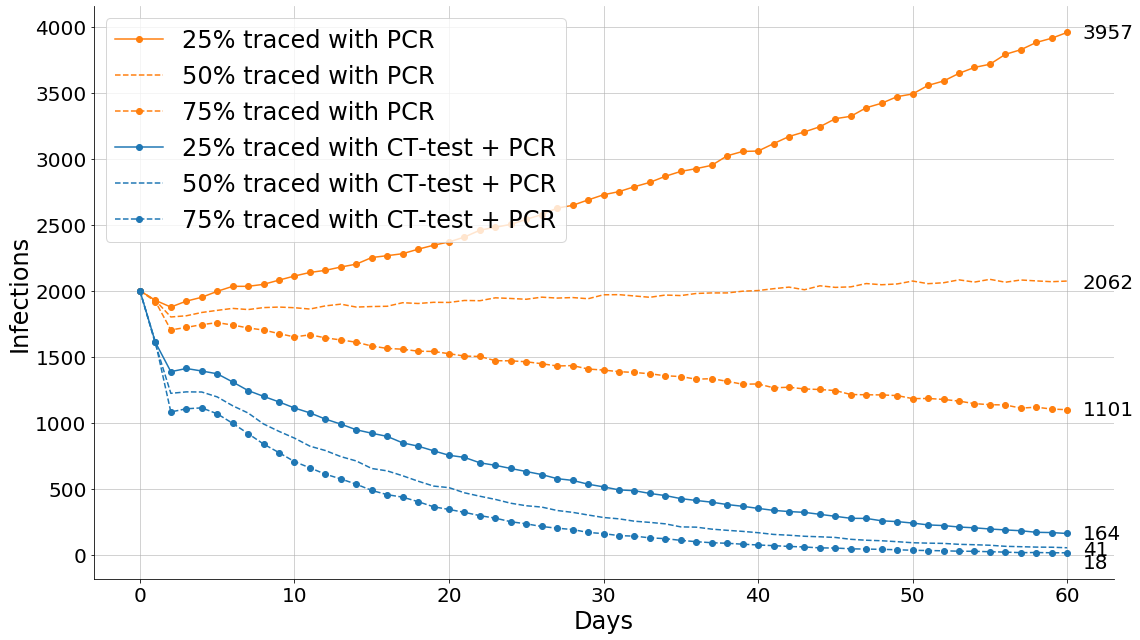

In [1019]:
# for different tract rate
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(16,9))

ax.plot(history1a.infected.diff()[offset_days:].reset_index(drop=True), 'o-',c='C1', label='25% traced with PCR')
ax.plot(history1b.infected.diff()[offset_days:].reset_index(drop=True), '--',c='C1', label='50% traced with PCR')
ax.plot(history1c.infected.diff()[offset_days:].reset_index(drop=True), 'o--',c='C1', label='75% traced with PCR')
ax.plot(history2a.infected.diff()[offset_days:].reset_index(drop=True), 'o-',c='C0', label='25% traced with CT-test + PCR')
ax.plot(history2b.infected.diff()[offset_days:].reset_index(drop=True), '--',c='C0', label='50% traced with CT-test + PCR')
ax.plot(history2c.infected.diff()[offset_days:].reset_index(drop=True), 'o--',c='C0', label='75% traced with CT-test + PCR')

for i in [history1a, history1c,
          history2a, 
#           history2b, 
#           history2c
         ]:
    ax.annotate(int(i.infected.diff().values[-1]),
                xy=(len(i)-offset_days,i.infected.diff().values[-1]),va='center',ha='left',fontsize=20)

i = history1b.copy()
ax.annotate(2062,
                xy=(len(i)-offset_days,2062),va='center',ha='left',fontsize=20)

    
i = history2b.copy()
ax.annotate(41,
                xy=(len(i)-offset_days,41),va='center',ha='left',fontsize=20)

i = history2c.copy()
ax.annotate(18,
                xy=(len(i)-offset_days,-60),va='center',ha='left',fontsize=20)
# i = history2c.copy()
# ax.annotate(int(i.infected.diff().values[-1]),
#                 xy=(len(i)-offset_days,int(i.infected.diff().values[-1])-60),va='center',ha='left',fontsize=20)
    

ax.set_ylabel('Infections',fontsize=24)
ax.set_xlabel('Days', fontsize=24)

ax.tick_params(labelsize=20)
ax.legend(loc=0, fontsize=24)

ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[10]))

ax.grid(alpha=0.7)
plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# name = 'trace_rate_r1.25'
# with open(r'simulation/Simulation_result_%s.pkl'%name, 'wb') as output:
#     pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)
# with open(r'simulation/Simulation_result_%s.pkl'%name, 'rb') as input:
#     t = pickle.load(input)
# plt.savefig(r'figures/for paper/CT/Fig_11.png', dpi=100)

# Output figures

In [84]:
t_Simulation_result_ct_r125_new = t.copy()

In [451]:
scale = 10.15
count = len(t)

history1 = (reduce(do_sum, [t[i][0] for i in range(count)])/count * scale).astype(int)
history2 = (reduce(do_sum, [t[i][1] for i in range(count)])/count * scale).astype(int)
history2a = (reduce(do_sum, [t[i][2] for i in range(count)])/count * scale).astype(int)
history3 = (reduce(do_sum, [t[i][3] for i in range(count)])/count * scale).astype(int)
history3a = (reduce(do_sum, [t[i][4] for i in range(count)])/count * scale).astype(int)

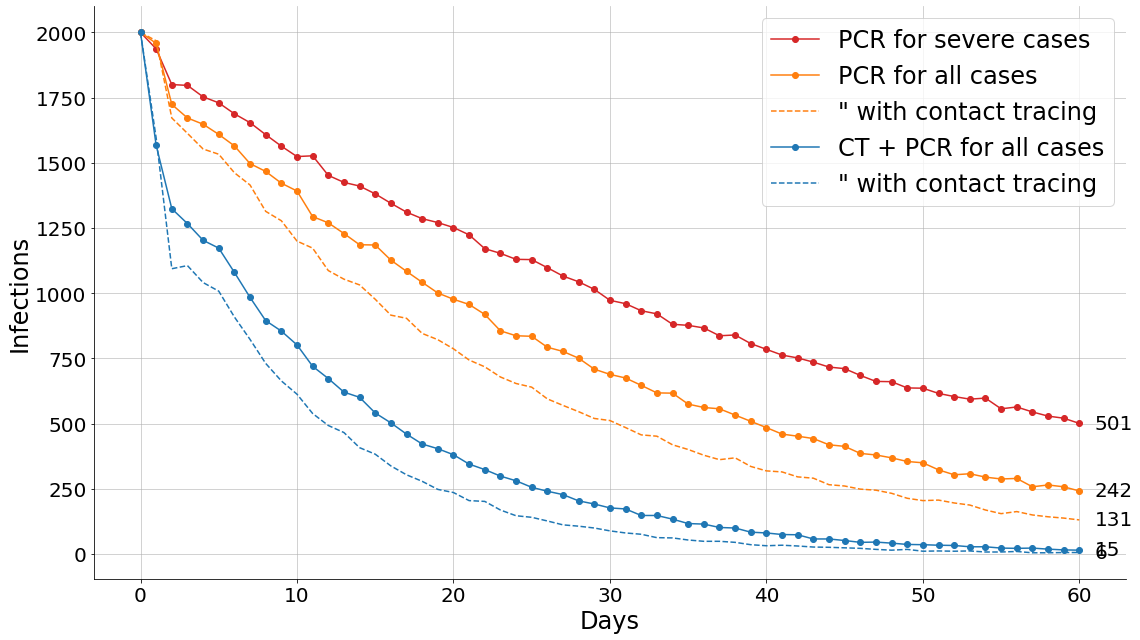

In [452]:
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(16,9))

ax.plot(history1.infected.diff()[20:].reset_index(drop=True), 'o-',c='C3', label='PCR for severe cases')
ax.plot(history2.infected.diff()[20:].reset_index(drop=True), 'o-',c='C1', label='PCR for all cases')
ax.plot(history2a.infected.diff()[20:].reset_index(drop=True), '--',c='C1', label='\" with contact tracing')
ax.plot(history3.infected.diff()[20:].reset_index(drop=True), 'o-',c='C0', label='CT + PCR for all cases')
ax.plot(history3a.infected.diff()[20:].reset_index(drop=True), '--',c='C0', label='\" with contact tracing')

for i in [history1, history2, history3,
          history2a, history3a
         ]:
    ax.annotate(int(i.infected.diff().values[-1]),
                xy=(len(i)-20,i.infected.diff().values[-1]),va='center',ha='left',fontsize=20)
# i = history3.copy()
# ax.annotate(int(99),
#                 xy=(len(i)-20,99),va='center',ha='left',fontsize=20)
    

ax.set_ylabel('Infections',fontsize=24)
ax.set_xlabel('Days', fontsize=24)

ax.tick_params(labelsize=20)
ax.legend(loc=0, fontsize=24)

ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[10]))

ax.grid(alpha=0.7)
plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('figures/for paper/Simulation_result_sct85b.png', dpi=600)

# Analyticals

## How many infections will be prevented by screen one

In [1162]:
a,b = [],[]
r = 1.25

for i in range(10000):
    onset_day = int(np.random.weibull(a=2.04) / 0.103)

    infection_a = 0
    infection_b = 0

    for day in range(min(onset_day + 3, 13)):
        infection_a += r * beta_t[day]
    if onset_day + 3 < 13 and np.random.random() < 0.3:
        for day in range(onset_day+4, 13):
            infection_a += r * beta_t[day]

    for day in range(min(onset_day, 13)):
        infection_b += r * beta_t[day]
    if onset_day + 1 < 13 and np.random.random() < 0.05:
        for day in range(onset_day+4, 13):
            infection_b += r * beta_t[day]
        
    a.append(infection_a)
    b.append(infection_b)
    
np.array(b).mean() / np.array(a).mean()


0.755551849769321

In [1166]:
np.array(b).mean()

0.8515929109749999

$R^\frac{60}{T} \times(1-(\frac{3}{4})^{\frac{60}{T}})$

In [738]:
r=1.06
print((1-(3/4)**9) * r**9)
print((1-(3/4)**12) * r**12)

1.5626249613905026
1.9484574280520799


## Reduction of different strategies

In [1763]:
def get_Weibull_CDF(x):
    return len(sample[sample <= x])/ len(sample)
    
get_Weibull_CDF(-2)

0.0

In [1864]:
p_a = 0.05
p_m = 0.75
p_s = 0.2
f_p = 0.3
f_c = 0.05

y_a = 0.1
R = 1

In [1819]:
ff = 0
for i in range(14):
    ff += get_Weibull_CDF(i) - get_Weibull_CDF(i-1)
ff

0.8370892

In [1853]:
t1 = 0
for ip in range(14):
    seg_sum = 0
    for j in range(ip+4):
        if j <= 13:
            seg_sum += beta_t[j]
    t1 += (get_Weibull_CDF(ip) - get_Weibull_CDF(ip-1)) * seg_sum

In [1854]:
t2 = 0
for ip in range(14):
    seg_sum = 0
    for j in range(ip+1):
        if j <= 13:
            seg_sum += beta_t[j]
    t2 += (get_Weibull_CDF(ip) - get_Weibull_CDF(ip-1)) * seg_sum

In [1807]:
sum_tau = 0
for i in range(14):
    sum_tau += beta_t[i] * get_Weibull_CDF(i)
sum_tau

0.24063944203813997

In [1879]:
sum_tau_1 = 0
for i in range(14):
    sum_tau_1 += beta_t[i] * (get_Weibull_CDF(i + 4) - get_Weibull_CDF(i))
    
sum_tau_2 = 0
for i in range(14):
    sum_tau_2 += beta_t[i] * (get_Weibull_CDF(i + 1) - get_Weibull_CDF(i))
    

In [1872]:
R0 = p_a * y_a * R + p_m * R + p_s * R
R0

0.9550000000000001

### Yaneer

In [1880]:
R1 = p_a * y_a * R + p_m * R + p_s * R * (f_p + (1-f_p) * sum_tau_1)
R1

0.8594723200349204

In [1881]:
R2 = p_a * y_a * R + (p_m + p_s) * R * (f_p + (1-f_p) * sum_tau_1)
R2

0.5012435201658718

In [1882]:
R3 = p_a * y_a * R + (p_m + p_s) * R * (f_p + (1-f_p) * sum_tau_2)
R3

0.34038710218543605

### Mine

In [1964]:
R1 = p_a * y_a * R + p_m * R + p_s * R * (f_p + (1-f_p) * t1)
R1 / R0

0.9699620989014668

In [1970]:
R2 = p_a * y_a * R + (p_m + p_s) * R * (f_p + (1-f_p) * t1)
R2 / R0

0.8573199697819671

In [1962]:
R4 = p_a * y_a * R + (p_m + p_s) * R * (f_p + (1-f_p) * t2)
R4 / R0

0.766041379525309

In [1915]:
beta_t[0] + beta_t[1] + beta_t[2] + beta_t[3]

0.2642838

In [1923]:
beta_t[0]

0.0030002

$\displaystyle R_1=p_a\eta_aR^* + p_mR^* + F_pp_sR^* + (1-F_p)p_sR^*(\sum_{i=0}W(i)\sum_{\tau=0}^{i+4}\beta(\tau))$

In [1887]:
np.random.weibull(a=2.04) / 0.103

7.417979514440127

## Calculate by ratio between generations

In [ ]:
r106_noct = []
p_severity = [0.05, 0.75, 0.2] # asymptomatic/mild/severe ratio. 
s_pcr = 0.7 #sensitivy of PCR test
s_ct = 0.95 #sensitivity of CT test
onetest = False

for i in range(1000):
    world = World(10)
    offset_days = 30
    for i in range(offset_days):
        world.step(r=1.06,
                  d_s=4,
                  d_m=4,
                  tp_m=1,               
                  trace_rate=0,
                  onetest=False)

    r106_noct.append(world.history.infected.iloc[-1])

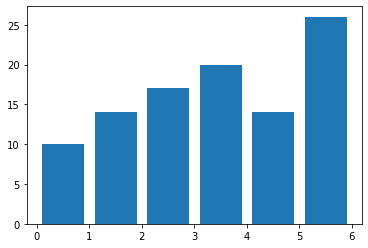

In [2215]:
# plt.hist(np.array([i.generation for i in world.cohort]), label=True, rwidth=0.8)
a = plt.hist(np.array([i.generation for i in world.cohort]), bins=range(np.array([i.generation for i in world.cohort]).max()),label=True, rwidth=0.8)


np.array(k).mean() 2097.44
np.array(k).std() 51.824187403180765

In [1309]:
np.array([1.19,1.11,1,0.91,0.78]) / 1.25

array([0.952, 0.888, 0.8  , 0.728, 0.624])

In [1310]:
np.array([1, 0.95,0.85,0.75,0.63]) / 1.06

array([0.94339623, 0.89622642, 0.80188679, 0.70754717, 0.59433962])

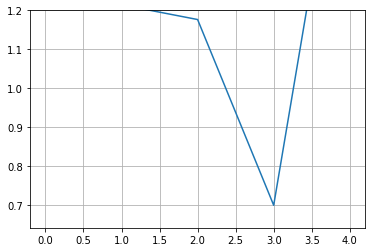

In [2220]:
fig, ax=plt.subplots()
ax.plot(a[0][1:] / a[0][:-1])
ax.set_ylim(top=1.2)
ax.grid()

# Draw life lines of patients

## Special class to keep track of events

In [2244]:
# v0.75 Just for plot the lifelines 

p_severity = [0.05, 0.75, 0.2] # asymptomatic/mild/severe ratio. 
s_pcr = 0.7 #sensitivy of PCR test
s_ct = 0.95 #sensitivity of CT test
onetest = True

"""
s_pcr: sensitivity of PCR test (right now undifferentiated between mild and severe cases and time, worth consider)
s_ct: sensitivity of CT test (right now not varied based on time)
d_s: delay between symptom onset and isolation (due to positive PCR test) for severe cases
d_m: delay between symptom onset and isolation (due to positive PCR test) for mild cases
tp_m: the chance a mild case get tested (daily)
trace_rate: the fraction of an indentified case' contacts that is quarantined
ct: whether to use CT as pre-screening
"""


class World:
    def __init__(self, initial_infection):
            self.day = 0 # time counter
            self.cohort = [] # list to store all the Patient objects
            for i in range(initial_infection): 
                self.cohort.append(
                    Patient(infection_day = self.day, my_id=i, close_contacts=[],
                                          my_type=np.random.choice(3, p=p_severity), generation=0)
                )
            self.history = pd.DataFrame() # data recording
            self.report_today = 0 # everyday's confirm cases, as opposed to infections
            self.trace_cases = [] # used to keep record of identified cases today for contact tracing
            self.update() # update all attributes
            self.test_history = []
            
    def update(self):
        self.infected = len(self.cohort) # total number of infections
        
        self.asyptomatic = pd.Series(i.id for i in self.cohort if i.type == 0)
        self.mild = pd.Series(i.id for i in self.cohort if i.type == 1)
        self.severe = pd.Series(i.id for i in self.cohort if i.type == 2)
        self.isolated = pd.Series(i.id for i in self.cohort if i.type == 3) # when a case is tested positive by PCR
        self.traced = pd.Series(i.id for i in self.cohort if i.type == 4) # when a case is isolated from contact tracing
        self.screened = pd.Series(i.id for i in self.cohort if i.type == 5) # when a case is screened positive by CT
        
        self.history.at[self.day, 'infected'] = self.infected
        self.history.at[self.day, 'asyptomatic'] = len(self.asyptomatic)
        self.history.at[self.day, 'mild'] = len(self.mild)
        self.history.at[self.day, 'severe'] = len(self.severe)
        self.history.at[self.day, 'isolated'] = len(self.isolated)
        self.history.at[self.day, 'traced'] = len(self.traced)
        self.history.at[self.day, 'screened'] = len(self.traced)
        self.history.at[self.day, 'report'] = self.report_today
    
        self.history = self.history.astype(int)
        for i in self.cohort:
            i.history.append(i.type)
        
    def step(self, r, d_s=4, d_m=4, tp_m=0, trace_rate=0, ct=0, onetest=False):
        self.day += 1
        self.report_today = 0
        self.trace_cases = [] # reset list for contact tracing, optional
        self.test(d_s, d_m, tp_m, ct, onetest)
        self.transmit(r)
        self.trace(trace_rate)
        self.referral()
        self.update()
        
    
    def test(self, d_s, d_m, tp_m, ct, onetest):
        if ct> 0 :
            for i in self.severe:
                if self.cohort[i].onset_day + 1 <= self.day:
                    self.test_history.append((self.day, i, 0))
                    if  np.random.random() < s_ct:
                        self.cohort[i].type = 5
                        self.report_today += 1
                        self.trace_cases.append(i)
                    
            for i in self.mild:
                if (not self.cohort[i].tested) and self.cohort[i].onset_day + 1 <= self.day:
                    self.test_history.append((self.day, i, 0))
                    if np.random.random() < s_ct:
                        self.cohort[i].type = 5
                        self.report_today += 1
                        self.trace_cases.append(i)
                    elif onetest:
                        self.cohort[i].tested = True
                    
        for i in self.severe:
            if self.cohort[i].onset_day + d_s <= self.day:
                self.test_history.append((self.day, i, 1))
                if np.random.random() < s_pcr:
                    self.cohort[i].type = 3
                    self.report_today += 1
                    self.trace_cases.append(i)
                
        if tp_m > 0:
            for i in self.mild:
                if (not self.cohort[i].tested) and self.cohort[i].onset_day + d_m <= self.day:
                    self.test_history.append((self.day, i, 1))
                    if np.random.random() < s_pcr:                
                        self.cohort[i].type = 3
                        self.report_today += 1
                        self.trace_cases.append(i)
                    elif onetest:
                        self.cohort[i].tested = True
                    
    def transmit(self, r):
        """
        Assuming asymptomatic individuals have transmicity 1/10 of presymptomatic/symptomatic individuals, based on 
        Quantifying SARS-CoV-2 transmission suggests epidemic control with digital contact tracing
        """
        for i in self.cohort:
            if i.type == 1 or i.type == 2:
                i.patient_infect(self.day, r)
            if i.type == 0:
                i.patient_infect(self.day, r/10)
                
    def trace(self, trace_rate):
        if trace_rate > 0:
            for i in self.trace_cases:
                for j in self.cohort[i].close_contacts:
                    if self.cohort[j].type in [0,1,2] and np.random.random() < trace_rate:
                        self.cohort[j].type = 4
                        
    def referral(self):
        for i in self.traced:
            if self.cohort[i].onset_day <= self.day:
                self.cohort[i].type = 3
                self.report_today += 1
                
        for i in self.screened:
            if self.cohort[i].onset_day <= self.day:
                self.cohort[i].type = 3
                self.report_today += 1                    
                    
        
        
class Patient:
    def __init__(self, infection_day, my_id, close_contacts, my_type, generation):
        self.infection_day = infection_day
        self.onset_day = int(np.random.weibull(a=2.04) / 0.103) + self.infection_day
        self.id = my_id
        self.close_contacts = []
        self.type = my_type
        self.tested = False
        self.generation = generation
        self.history = []
        
    def patient_infect(self, day, r):
        tau = int(day - self.infection_day)
        if tau <= 13 and self.type in [0,1,2]:
            if np.random.random() < r * beta_t[tau]:
                world.cohort.append(
                    Patient(infection_day=day, my_id=len(world.cohort), close_contacts=[],
                                           my_type=np.random.choice(3, p=p_severity), generation=self.generation+1)
                )
                self.close_contacts.append((day, self.id, len(world.cohort)-1))
            

## Find typical result

In [2349]:
set_default()
r106_ct_endinfection = []
offset_days = 60
n = 5000

for i in range(n):
    world = World(10)    
    for i in range(offset_days):
        world.step(r=1.06,
                  d_s=4,
                  d_m=4,
                  tp_m=1,
                   ct=1,
                  trace_rate=0,
                  onetest=False)
    r106_ct_endinfection.append(world.history.infected.iloc[-1])

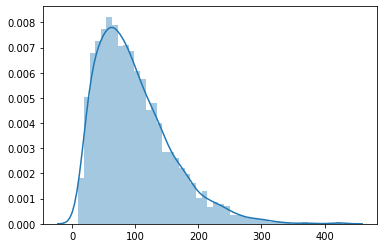

In [2350]:
sns.distplot(r106_noct_endinfection)

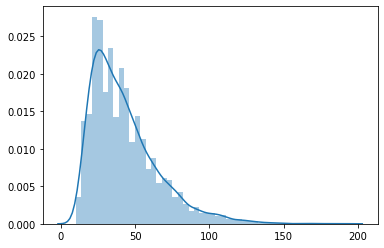

In [2351]:
sns.distplot(r106_ct_endinfection)

[Text(0.5, 0, '')]

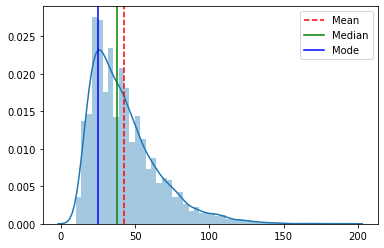

In [2488]:
inset_data = np.array(r106_ct_endinfection)

fig, ax2 = plt.subplots()

mean=inset_data.mean()
median=np.median(inset_data)
mode=scipy.stats.mode(inset_data)[0][0]


sns.distplot(inset_data, ax=ax2, bins=50)
ax2.axvline(mean, color='r', linestyle='--')
ax2.axvline(median, color='g', linestyle='-')
ax2.axvline(mode, color='b', linestyle='-')
ax2.legend({'Mean':mean,'Median':median,'Mode':mode})

ax2.set(xlabel='')

## Make lifelines and plots them

2.0


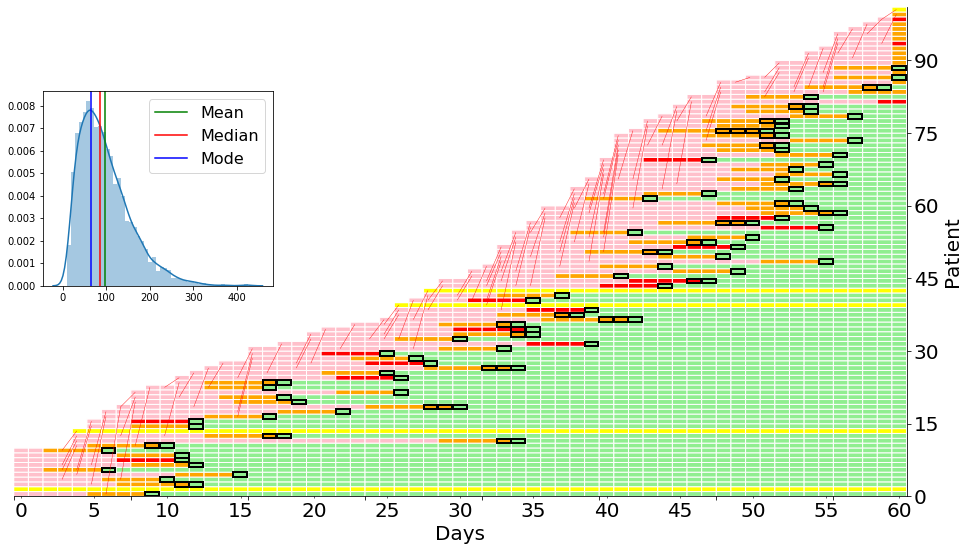

In [2482]:
# Initialize and run the simulation (with small number and days)
p_severity = [0.05, 0.75, 0.2] # asymptomatic/mild/severe ratio. 
s_pcr = 0.7 #sensitivy of PCR test
s_ct = 0.95 #sensitivity of CT test
onetest = False

world = World(10)
offset_days = 60
for i in range(offset_days):
    world.step(r=1.06,
              d_s=4,
              d_m=4,
              tp_m=1,
                ct=0,
              trace_rate=0,
              onetest=False)

initial = copy.deepcopy(world)
print(initial.history.infected.diff().iloc[-1])

# Process the life lines
# use -2 for patients yet infected
for i in world.cohort:
    while len(i.history) < world.day+1:
        i.history.insert(0, -2)

# colormap as a df to store all lifelines
colormap = pd.DataFrame([i.history for i in world.cohort])
        
# use -1 to overide 1,2 for presymtomatic cases    
for i in range(len(world.cohort)):
    if world.cohort[i].type:
        for j in range(world.cohort[i].onset_day):
            if j < world.day and colormap.at[i, j] != -2:
                colormap.at[i, j] = -1
                
# make a list of all transmission
transmission_chain = []
for i in world.cohort:
    for j in i.close_contacts:
        transmission_chain.append(j)
        
# plot
fix, ax = plt.subplots(figsize=(16,9))

cmap = colors.ListedColormap(['white','pink','yellow','orange','red','lightgreen','purple','lightgreen'])
bounds=[-2,-1,0,1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)
heatmap = ax.pcolor(colormap, cmap=cmap, norm=norm,
                    edgecolors='white', linewidths=1)

for chain in transmission_chain[:]:
    plt.arrow(chain[0]-0.7, chain[1]+0.5, 1, chain[2]-chain[1], alpha=0.5, lw=0.4,color='red')

for test in world.test_history:
    if test[2] == 0:
        rect = patches.Rectangle((test[0],test[1]), 0.95,0.95 , linewidth=2,ls='--', edgecolor='blue',fill=None)
    if test[2] == 1:    
        rect = patches.Rectangle((test[0],test[1]), 0.95,0.95 , linewidth=2,edgecolor='black',fill=None)
    ax.add_patch(rect)



ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.5, world.day+1.5, 5)))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(np.arange(0, world.day+1, 5)))

    
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.yaxis.tick_right()
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x',which='minor', labelsize=20)
ax.tick_params(axis='y',which='major', labelsize=20)
ax.set_xlabel('Days',fontsize=20)
ax.set_ylabel('Patient',fontsize=20)
ax.yaxis.set_label_position('right')

ax2 = plt.axes([0.15, 0.45, 0.2, 0.3])
inset_data = np.array(r106_noct_endinfection)

# fig, ax2 = plt.subplots()
mean=inset_data.mean()
median=np.median(inset_data)
mode=scipy.stats.mode(inset_data)[0][0]

sns.distplot(inset_data, ax=ax2)
ax2.axvline(mean, color='g')
ax2.axvline(median, color='r')
ax2.axvline(mode, color='b')
ax2.legend({'Mean':mean,'Median':median,'Mode':mode}, fontsize=16)

ax2.set(xlabel='')
plt.show()

# ax2.spines['left'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)


# plt.savefig('figures/for paper/CT/Fig_Viz_R106_CT.png', dpi=100)

## Output figures

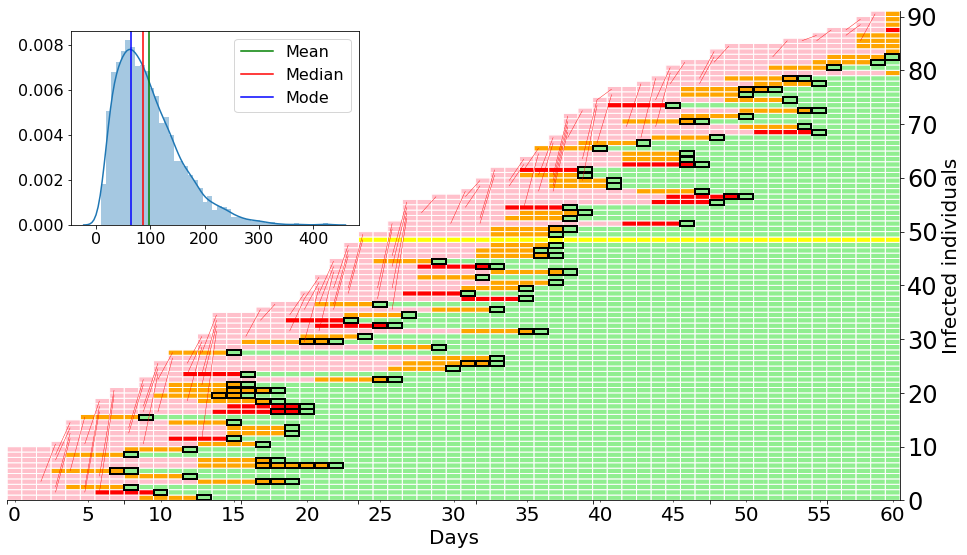

In [2470]:
# plot
fix, ax = plt.subplots(figsize=(16,9))

cmap = colors.ListedColormap(['white','pink','yellow','orange','red','lightgreen','purple','lightgreen'])
bounds=[-2,-1,0,1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)
heatmap = ax.pcolor(colormap, cmap=cmap, norm=norm,
                    edgecolors='white', linewidths=1)

for chain in transmission_chain[:]:
    plt.arrow(chain[0]-0.7, chain[1]+0.5, 1, chain[2]-chain[1], alpha=0.5, lw=0.4,color='red')

for test in world.test_history:
    if test[2] == 0:
        rect = patches.Rectangle((test[0],test[1]), 0.95,0.95 , linewidth=2,ls='--', edgecolor='blue',fill=None)
    if test[2] == 1:    
        rect = patches.Rectangle((test[0],test[1]), 0.95,0.95 , linewidth=2,edgecolor='black',fill=None)
    ax.add_patch(rect)



ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.5, world.day+1.5, 5)))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(np.arange(0, world.day+1, 5)))

    
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.yaxis.tick_right()
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x',which='minor', labelsize=20)
ax.tick_params(axis='y',which='major', labelsize=20)
ax.set_xlabel('Days',fontsize=20)
ax.set_ylabel('Infected individuals',fontsize=20)
ax.yaxis.set_label_position('right')

ax2 = plt.axes([0.18, 0.55, 0.25, 0.3])
# ax2 = plt.axes([0.55, 0.2, 0.3, 0.4])
inset_data = np.array(r106_noct_endinfection)

# fig, ax2 = plt.subplots()
mean=inset_data.mean()
median=np.median(inset_data)
mode=scipy.stats.mode(inset_data)[0][0]

sns.distplot(inset_data, ax=ax2)
ax2.axvline(mean, color='g')
ax2.axvline(median, color='r')
ax2.axvline(mode, color='b')
ax2.legend({'Mean':mean,'Median':median,'Mode':mode}, fontsize=16)
ax.tick_params(labelsize=24)
ax2.tick_params(labelsize=16)
ax2.set(xlabel='')


# ax2.spines['left'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)

# plt.savefig('figures/for paper/CT/Fig_Viz_R106_noCT_hist.png', dpi=100)

### Vertical version

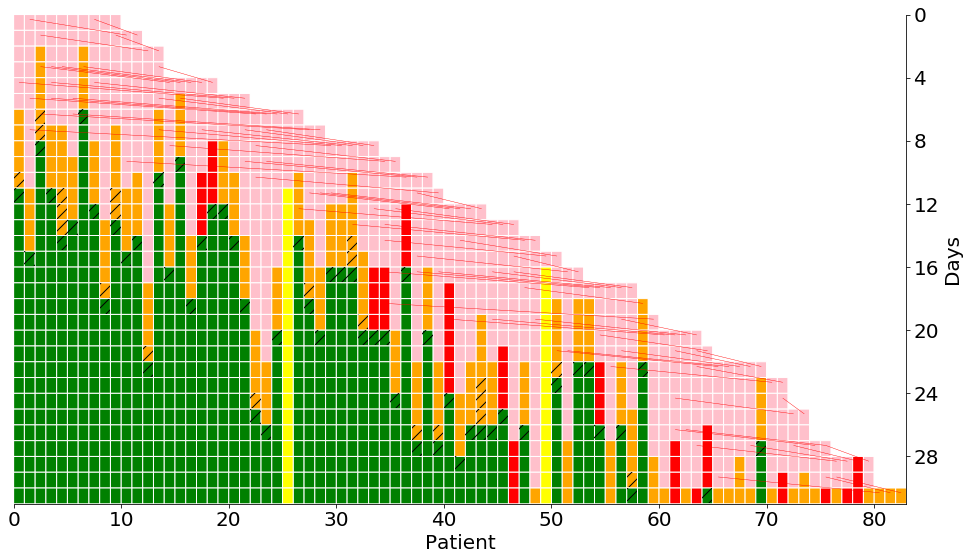

In [1732]:
from matplotlib import colors
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker

fix, ax = plt.subplots(figsize=(16,9))

cmap = colors.ListedColormap(['white','pink','yellow','orange','red','green','purple','skyblue'])
bounds=[-2,-1,0,1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)
heatmap = ax.pcolor(colormap.T, cmap=cmap, norm=norm,
                    edgecolors='white', linewidths=1)

for chain in transmission_chain[:]:
#     plt.arrow(chain[0]-0.7, chain[1]+0.5, 1, chain[2]-chain[1], alpha=0.5, lw=0.4,color='red')
    plt.arrow(y=chain[0]-0.7, x=chain[1]+0.5, dy=1, dx=chain[2]-chain[1], alpha=0.5, lw=0.4,color='red')

for test in world.test_history:
    rect = patches.Rectangle((test[1],test[0]), 0.95,0.95 , linewidth=0.001,edgecolor=None,fill=None,hatch='//')
    ax.add_patch(rect)



# ax.xaxis.set_major_formatter(ticker.NullFormatter())
# ax.xaxis.set_minor_locator(ticker.FixedLocator([i+0.5 for i in range(len(world.cohort))]))
# ax.xaxis.set_minor_formatter(ticker.FixedFormatter(range(len(world.cohort))))

# ax.yaxis.set_major_formatter(ticker.NullFormatter())
# ax.yaxis.set_minor_locator(ticker.FixedLocator([i+0.5 for i in range(1, len(world.cohort)+1)]))
# ax.yaxis.set_minor_formatter(ticker.FixedFormatter(range(1, len(world.cohort)+1)))

    
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.yaxis.tick_right()
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x',which='major', labelsize=20)
ax.tick_params(axis='y',which='major', labelsize=20)
ax.set_ylabel('Days',fontsize=20)
ax.set_xlabel('Patient',fontsize=20)
ax.yaxis.set_label_position('right')
# ax.tick_params(axis='both', labelsize=28)
plt.gca().invert_yaxis()